# 4-二维的PCA

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="white")

import numpy as np
import pandas as pd
import scipy.io as sio

# load data

In [7]:
def get_X(df):
    """
    use concat to add intersect feature to avoid side effect
    not efficient for big dataset though
    """
    ones = pd.DataFrame({'ones': np.ones(len(df))})
    data = pd.concat([ones, df], axis=1)  # column concat
    return data.iloc[:, :-1].as_matrix()  # this return ndarray, not matrix


def get_y(df):
    '''assume the last column is the target'''
    return np.array(df.iloc[:, -1])


def normalize_feature(df):
    """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())


In [10]:
mat = sio.loadmat('./data/ex7data1.mat')
X = mat.get('X')

# visualize raw data
print(X.shape)

(50, 2)


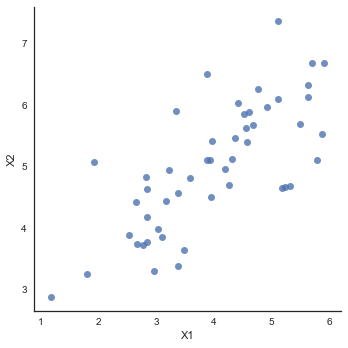

In [11]:
sns.lmplot('X1', 'X2', 
           data=pd.DataFrame(X, columns=['X1', 'X2']),
           fit_reg=False)
plt.show()

# normalize data

In [12]:
# support functions ---------------------------------------
def plot_n_image(X, n):
    """ plot first n images
    n has to be a square number
    """
    pic_size = int(np.sqrt(X.shape[1]))
    grid_size = int(np.sqrt(n))

    first_n_images = X[:n, :]

    fig, ax_array = plt.subplots(nrows=grid_size, ncols=grid_size,
                                    sharey=True, sharex=True, figsize=(8, 8))

    for r in range(grid_size):
        for c in range(grid_size):
            ax_array[r, c].imshow(first_n_images[grid_size * r + c].reshape((pic_size, pic_size)))
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))


# PCA functions ---------------------------------------
def covariance_matrix(X):
    """
    Args:
        X (ndarray) (m, n)
    Return:
        cov_mat (ndarray) (n, n):
            covariance matrix of X
    """
    m = X.shape[0]

    return (X.T @ X) / m


def normalize(X):
    """
        for each column, X-mean / std
    """
    X_copy = X.copy()
    m, n = X_copy.shape

    for col in range(n):
        X_copy[:, col] = (X_copy[:, col] - X_copy[:, col].mean()) / X_copy[:, col].std()

    return X_copy


def pca(X):
    """
    http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html
    Args:
        X ndarray(m, n)
    Returns:
        U ndarray(n, n): principle components
    """
    # 1. normalize data
    X_norm = normalize(X)

    # 2. calculate covariance matrix
    Sigma = covariance_matrix(X_norm)  # (n, n)

    # 3. do singular value decomposition
    # remeber, we feed cov matrix in SVD, since the cov matrix is symmetry
    # left sigular vector and right singular vector is the same, which means
    # U is V, so we could use either one to do dim reduction
    U, S, V = np.linalg.svd(Sigma)  # U: principle components (n, n)

    return U, S, V


def project_data(X, U, k):
    """
    Args:
        U (ndarray) (n, n)
    Return:
        projected X (n dim) at k dim
    """
    m, n = X.shape

    if k > n:
        raise ValueError('k should be lower dimension of n')

    return X @ U[:, :k]


def recover_data(Z, U):
    m, n = Z.shape

    if n >= U.shape[0]:
        raise ValueError('Z dimension is >= U, you should recover from lower dimension to higher')

    return Z @ U[:, :n].T


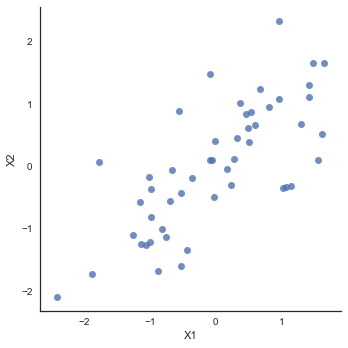

In [13]:
X_norm = normalize(X)

sns.lmplot('X1', 'X2', 
           data=pd.DataFrame(X_norm, columns=['X1', 'X2']),
           fit_reg=False)
plt.show()

# covariance matrix $\Sigma$
<img style="float: left;" src="../img/cov_mat.png">

this is biased sample covariance matrix, for unbiased version, you need to divide it by $m-1$

In [14]:
Sigma =covariance_matrix(X_norm)  # capital greek Sigma
Sigma  # (n, n)

array([[ 1.        ,  0.73553038],
       [ 0.73553038,  1.        ]])

# PCA
http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html

In [16]:
U, S, V = pca(X_norm)

In [17]:
U

array([[-0.70710678, -0.70710678],
       [-0.70710678,  0.70710678]])

In [18]:
u1 = U[0]
u1

array([-0.70710678, -0.70710678])

# project data to lower dimension

In [20]:
# show top 10 projected data
Z = project_data(X_norm, U, 1)
Z[:10]

array([[ 1.49631261],
       [-0.92218067],
       [ 1.22439232],
       [ 1.64386173],
       [ 1.2732206 ],
       [-0.97681976],
       [ 1.26881187],
       [-2.34148278],
       [-0.02999141],
       [-0.78171789]])

http://stackoverflow.com/a/23973562/3943702

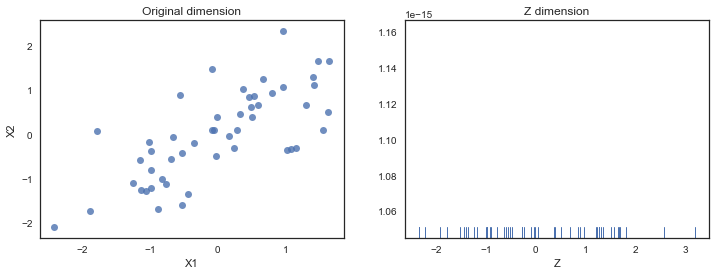

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

sns.regplot('X1', 'X2', 
           data=pd.DataFrame(X_norm, columns=['X1', 'X2']),
           fit_reg=False,
           ax=ax1)
ax1.set_title('Original dimension')

sns.rugplot(Z, ax=ax2)
ax2.set_xlabel('Z')
ax2.set_title('Z dimension')
plt.show()

# recover data to original dimension
Of course, there would be inevitable information loss if you boost data from lower to higher dimension

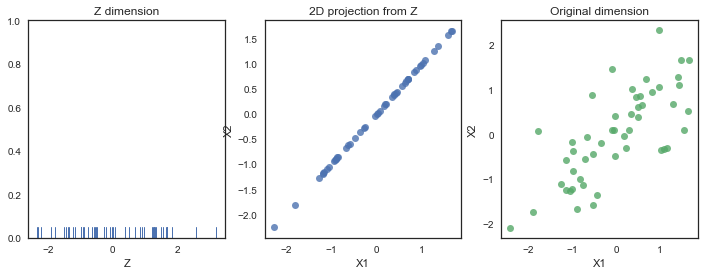

In [22]:
X_recover = recover_data(Z, U)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4))

sns.rugplot(Z, ax=ax1)
ax1.set_title('Z dimension')
ax1.set_xlabel('Z')

sns.regplot('X1', 'X2', 
           data=pd.DataFrame(X_recover, columns=['X1', 'X2']),
           fit_reg=False,
           ax=ax2)
ax2.set_title("2D projection from Z")

sns.regplot('X1', 'X2', 
           data=pd.DataFrame(X_norm, columns=['X1', 'X2']),
           fit_reg=False,
           ax=ax3)
ax3.set_title('Original dimension')
plt.show()

### the projection from `(X1, X2)` to `Z` could be visualized like this

<img style="float: central;" src="../img/pca_projection.png">